# Part 1: Human Activity Recognition (HAR)

## 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import pickle

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [3]:
train_df.isna().sum().sort_values(ascending=False)

tBodyAcc-mean()-X            0
fBodyAccJerk-kurtosis()-Y    0
fBodyAccJerk-meanFreq()-X    0
fBodyAccJerk-meanFreq()-Y    0
fBodyAccJerk-meanFreq()-Z    0
                            ..
tBodyGyroJerk-iqr()-Z        0
tBodyGyroJerk-iqr()-Y        0
tBodyGyroJerk-iqr()-X        0
tBodyGyroJerk-energy()-Z     0
Activity                     0
Length: 563, dtype: int64

In [4]:
test_df.isna().sum().sort_values(ascending=False)

tBodyAcc-mean()-X            0
fBodyAccJerk-kurtosis()-Y    0
fBodyAccJerk-meanFreq()-X    0
fBodyAccJerk-meanFreq()-Y    0
fBodyAccJerk-meanFreq()-Z    0
                            ..
tBodyGyroJerk-iqr()-Z        0
tBodyGyroJerk-iqr()-Y        0
tBodyGyroJerk-iqr()-X        0
tBodyGyroJerk-energy()-Z     0
Activity                     0
Length: 563, dtype: int64

In [5]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


In [6]:
pd.read_csv("data/test_missing_values.csv").isna().sum().sum() / pd.read_csv("data/test_missing_values.csv").notna().sum().sum()

0.05287937379571821

In [7]:
np.random.seed(42)

mask_5_percent_train = np.random.rand(*train_df.shape) < 0.05
mask_5_percent_test = np.random.rand(*test_df.shape) < 0.05

missing_vals_train_df = train_df.copy()
missing_vals_test_df = test_df.copy()

# Set 5% of the values to NaN, exluding class labels and subjects
missing_vals_train_df.iloc[:,:-2][mask_5_percent_train[:,:-2]] = np.nan
missing_vals_test_df.iloc[:,:-2][mask_5_percent_test[:,:-2]] = np.nan


# Remove 90% of WALKING_DOWNSTAIRS and WALKING_UPSTAIRS instances
walking_downstairs_and_upstairs_instances = train_df[(train_df["Activity"] == "WALKING_DOWNSTAIRS") | (train_df["Activity"] == "WALKING_UPSTAIRS")]
num_samples_to_draw = int(0.9 * len(walking_downstairs_and_upstairs_instances))
mask_90_percent = np.random.choice(walking_downstairs_and_upstairs_instances.index, num_samples_to_draw)
unbalanced_train_df = train_df.loc[~train_df.index.isin(mask_90_percent)]

In [8]:
# fill missing values with the mean by activity
mean_by_target = missing_vals_test_df.groupby('Activity').transform("mean")
missing_vals_test_df = missing_vals_test_df.combine_first(mean_by_target)
missing_vals_test_df.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)","fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1",...,tGravityAccMag-arCoeff()4,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std()
0,STANDING,-0.720009,0.276801,-0.057978,0.162920,0.006462,0.271151,-0.825886,-0.998204,-0.996071,...,-0.564449,-0.980166,0.255104,-0.859474,-0.744022,-0.760796,-0.866929,-0.981649,-0.866929,-0.705191
1,STANDING,-0.698091,0.281343,-0.083898,0.017500,-0.083495,0.920593,-0.434375,-0.999760,-0.999212,...,-0.348262,-0.998920,-0.329345,-0.976220,-0.963165,-0.937608,-0.968961,-0.985944,-0.968961,-0.953902
2,STANDING,-0.702771,0.280083,-0.079346,0.202302,-0.034956,0.145068,0.064103,-0.999962,-0.999305,...,-0.155699,-0.999424,-0.515362,-0.982905,-0.982364,-0.969212,-0.976228,-0.985944,-0.976228,-0.979083
3,STANDING,-0.698954,0.284114,-0.077108,0.154438,-0.017067,0.296407,0.340134,-0.999971,-0.999442,...,-0.134311,-0.999349,-0.486317,-0.984823,-0.981155,-0.969212,-0.974325,-0.986263,-0.974325,-0.977016
4,STANDING,-0.692245,0.290722,-0.073857,-0.040046,-0.002223,-0.118545,0.736715,-0.999960,-0.999115,...,-0.006066,-0.999395,-0.447049,-0.979044,-0.979237,-0.975954,-0.975836,-0.993228,-0.975836,-0.976893


## 2. Data exploration

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [10]:
for column in train_df.columns:
    if train_df[column].dtype == 'object':
        print(f"Column: {column}, Unique Values: {train_df[column].unique()}")
    if train_df[column].dtype == 'int64':
        print(f"Column: {column}, Unique Values: {train_df[column].unique()}")


Column: subject, Unique Values: [ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
Column: Activity, Unique Values: ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [11]:
train_df.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000


In [12]:
non_features = ["subject", "Activity"]
train_X = train_df.loc[:,~train_df.columns.isin(non_features)]
train_y = train_df.loc[:,"Activity"]
max_val = train_X.values.max()
min_val = train_X.values.min()
print("Max measure: ", max_val)
print("Min measure: ", min_val)

Max measure:  1.0
Min measure:  -1.0


<Axes: title={'center': 'Balanced training set'}, ylabel='Activity'>

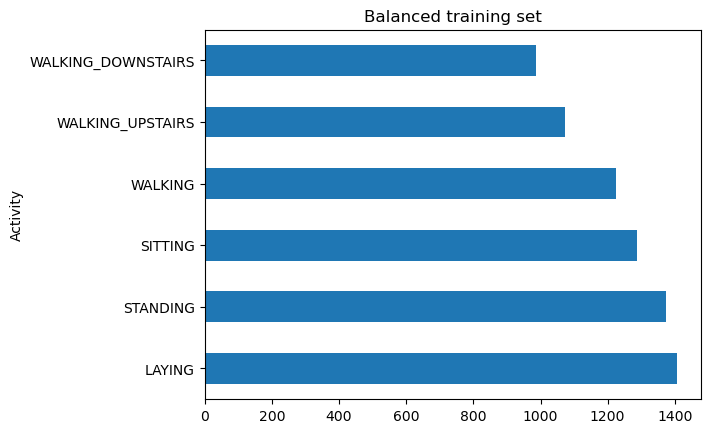

In [13]:
train_df.Activity.value_counts().plot(kind='barh', title="Balanced training set")

<Axes: title={'center': 'Unbalanced training set'}, ylabel='Activity'>

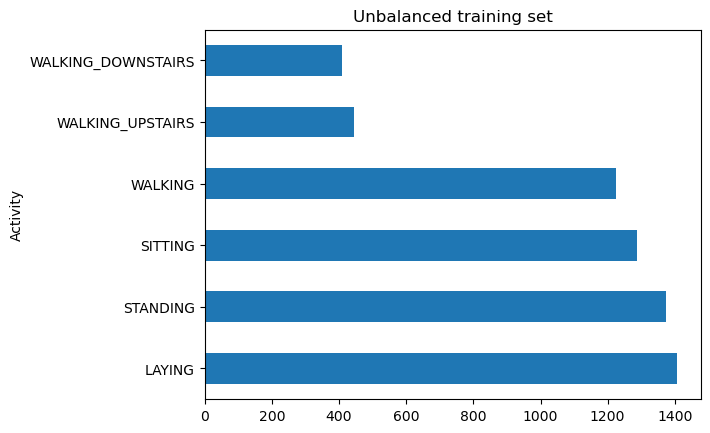

In [14]:
unbalanced_train_df.Activity.value_counts().plot(kind='barh', title="Unbalanced training set")

### Correlations

In [15]:
correlation_matrix = train_X.corr()
highly_correlated_pairs = correlation_matrix.abs() > 0.95 # check for high absolute correlations, including negative and positive correlations
highly_correlated_features = [(i, j) for i in range(correlation_matrix.shape[0]) for j in range(i + 1, correlation_matrix.shape[1]) if highly_correlated_pairs.iloc[i, j]]
len(highly_correlated_features)

2281

Text(0, 0.5, 'tBodyAcc-mad()-X')

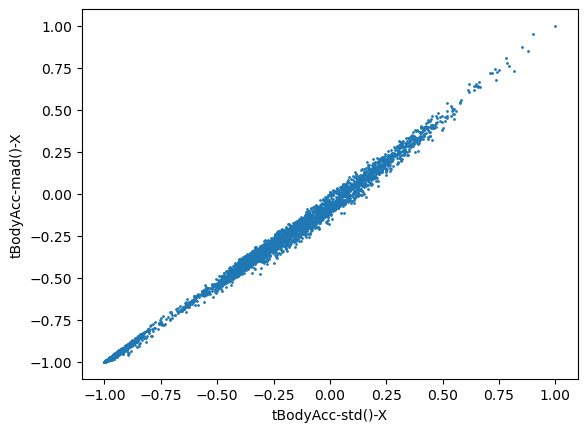

In [16]:
feature1 = train_X.columns[highly_correlated_features[0][0]]
feature2 = train_X.columns[highly_correlated_features[0][1]]

plt.scatter(train_X[feature1], train_X[feature2],s=1)
plt.xlabel(feature1)
plt.ylabel(feature2)

Text(0, 0.5, 'tBodyAccJerk-std()-X')

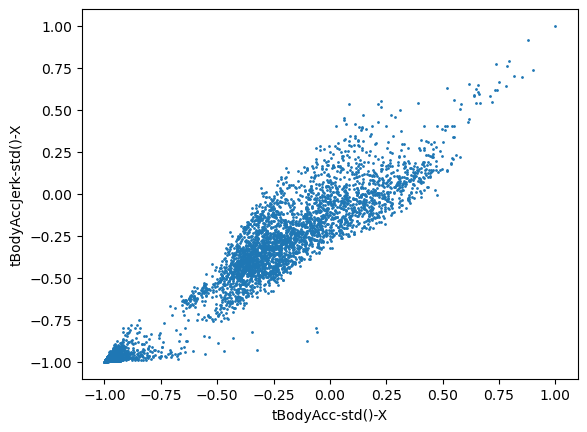

In [17]:
feature1 = train_X.columns[highly_correlated_features[5][0]]
feature2 = train_X.columns[highly_correlated_features[5][1]]

plt.scatter(train_X[feature1], train_X[feature2],s=1)
plt.xlabel(feature1)
plt.ylabel(feature2)

### Density plots by class

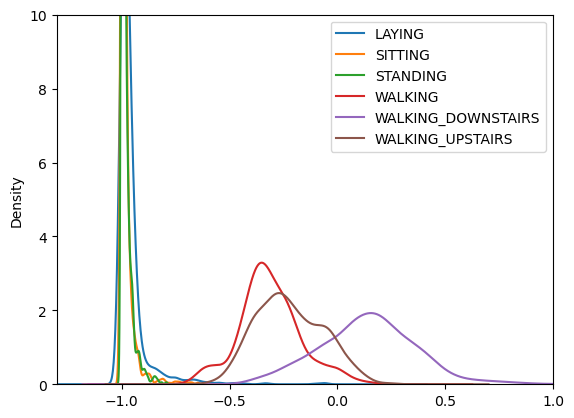

In [18]:
train_df.groupby('Activity')["tBodyAcc-std()-X"].plot.kde(legend=True, ylim=(0,10), xlim=(-1.3, 1), )
plt.show()

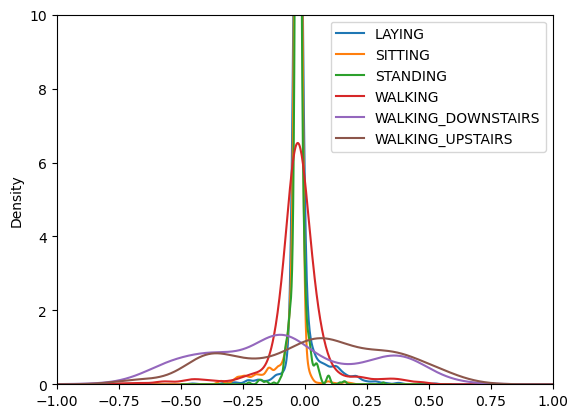

In [19]:
train_df.groupby('Activity')["tBodyGyro-mean()-X"].plot.kde(legend=True,ylim=(0,10), xlim=(-1,1))
plt.show()

## 3. Feature selection

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from ReliefF import ReliefF

def information_gain(X, y, k):
    mutual_info = SelectKBest(score_func=mutual_info_classif, k=k)
    fit = mutual_info.fit(X, y)
    selected_features = fit.get_support(indices=True)
    return selected_features


def relief(X,y,k, n_neighbors):
    fs = ReliefF(n_neighbors=n_neighbors, n_features_to_keep=k)
    fs.fit(X, y)
    return fs.top_features[:k]

In [21]:
X = train_X.to_numpy()
y = train_y.to_numpy()
top_features_relief = relief(X, y, k=10, n_neighbors=1)
train_df.iloc[:,top_features_relief[:3]].head()

,tGravityAcc-entropy()-Y,fBodyAcc-maxInds-Z,fBodyAcc-maxInds-X
0,-1.0,-1.0,-1.000000
1,-1.0,-1.0,0.096774
2,-1.0,-1.0,-0.935484
3,-1.0,-1.0,-1.000000
4,-1.0,-1.0,0.096774


In [23]:
select_features_ig = information_gain(X, y, 10)
train_X.iloc[:, select_features_ig[:3]].head()

,tBodyAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-min()-Y
0,-0.934724,-0.161265,-0.123213
1,-0.943068,-0.161343,-0.114893
2,-0.938692,-0.163711,-0.114893
3,-0.938692,-0.163711,-0.121336
4,-0.942469,-0.166786,-0.121834


## 4. Supervised classification models

### Relief selected features

In [26]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm.notebook import tqdm

# model initialization
svc = SVC(kernel="rbf")
rf = RandomForestClassifier()
lr = LogisticRegression()

accuracies = []
k_max = 110
k_vals = [k for k in range(10, k_max+1, 10)]

eval_svc = []
eval_rf = []
eval_lr = []

def evaluate(y_test, y_pred, average):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)
    return [accuracy, precision, recall, f1]

for k in tqdm(k_vals):
    # select k features
    select_features_relief = relief(X, y, k, n_neighbors=1)

    # Train the classifiers
    svc.fit(train_X.iloc[:, select_features_relief], y)
    rf.fit(train_X.iloc[:, select_features_relief], y)
    lr.fit(train_X.iloc[:, select_features_relief], y)

    with open(f'models/svc_{k}.pkl', 'wb') as file:
        pickle.dump(svc, file)

    with open(f'models/rf_{k}.pkl', 'wb') as file:
        pickle.dump(rf, file)
    
    with open(f'models/lr_{k}.pkl', 'wb') as file:
        pickle.dump(lr, file)


    # Make predictions on the test set
    test_X = test_df.iloc[:, select_features_relief]
    test_y = test_df["Activity"]
    y_pred_svc = svc.predict(test_X)
    y_pred_rf = rf.predict(test_X)
    y_pred_lr = lr.predict(test_X)

    # Evaluate the accuracy
    average = 'weighted'
    scores_svc = evaluate(test_y, y_pred_svc, average)
    scores_rf =  evaluate(test_y, y_pred_rf, average)
    scores_lr =  evaluate(test_y, y_pred_lr, average)

    eval_svc.append(scores_svc)
    eval_rf.append(scores_rf)
    eval_lr.append(scores_lr)

  0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

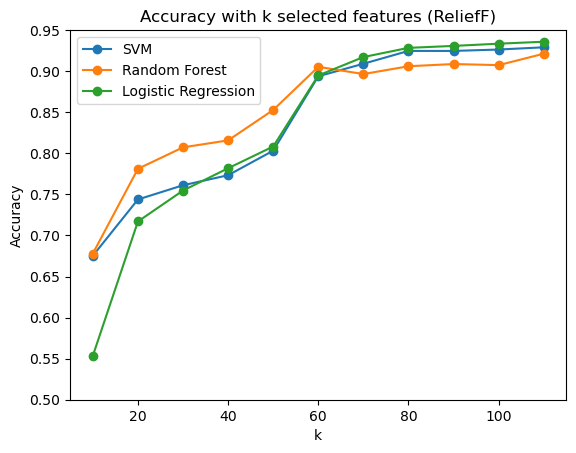

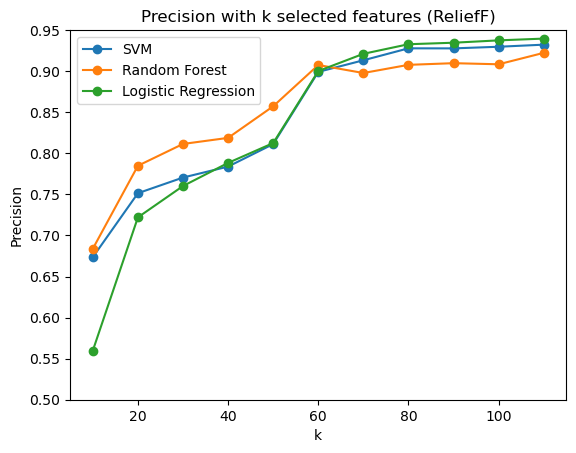

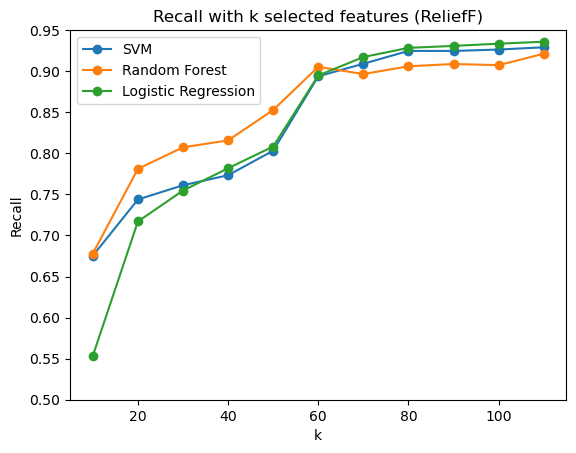

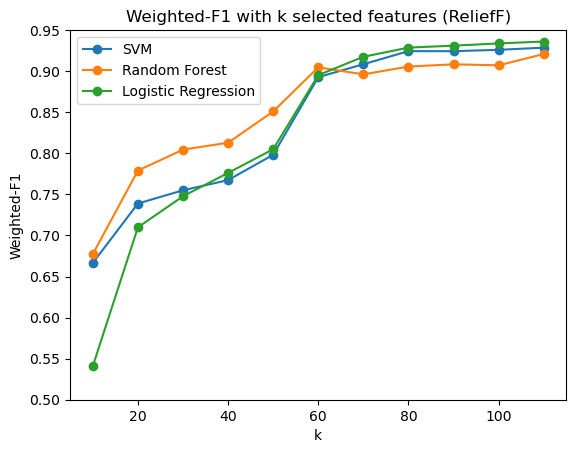

In [252]:
metrics = ["Accuracy", "Precision", "Recall", "Weighted-F1"]
metrics_abbrev = ["Acc", "Prec", "Rec", "F1"]

ylim = (0.5, 0.95)
for i, metric in enumerate(metrics):
    plt.plot(k_vals,[j[i] for j in eval_svc[:len(k_vals)]],'o-', label="SVM")
    plt.plot(k_vals,[j[i] for j in eval_rf[:len(k_vals)]],'o-', label="Random Forest")
    plt.plot(k_vals,[j[i] for j in eval_lr[:len(k_vals)]],'o-' ,label="Logistic Regression")

    plt.xlabel("k")
    plt.ylabel(metric)
    plt.title(f"{metric} with k selected features (ReliefF)")
    plt.ylim(ylim)
    plt.legend()
    plt.show()

In [253]:
result_overview_svc = pd.DataFrame(eval_svc, index=k_vals, columns=[f"SVM {metric}" for metric in metrics_abbrev])
result_overview_rf = pd.DataFrame(eval_rf, index=k_vals, columns=[f"RF {metric}" for metric in metrics_abbrev])
result_overview_lr = pd.DataFrame(eval_lr, index=k_vals, columns=[f"LR {metric}" for metric in metrics_abbrev])
result_overview = pd.concat([result_overview_svc, result_overview_rf, result_overview_lr], axis=1)
result_overview = result_overview.transform(lambda x: round(x, 3))
result_overview.index.name = "k"
result_overview.to_excel('performance_classifier.xlsx', index=True)
result_overview

,SVM Acc,SVM Prec,SVM Rec,SVM F1,RF Acc,RF Prec,RF Rec,RF F1,LR Acc,LR Prec,LR Rec,LR F1
k,,,,,,,,,,,,
10,0.675,0.674,0.675,0.667,0.678,0.684,0.678,0.677,0.553,0.560,0.553,0.541
20,0.744,0.751,0.744,0.739,0.781,0.785,0.781,0.779,0.717,0.722,0.717,0.710
30,0.761,0.770,0.761,0.755,0.807,0.811,0.807,0.804,0.755,0.760,0.755,0.748
40,0.773,0.784,0.773,0.767,0.816,0.819,0.816,0.813,0.782,0.788,0.782,0.776
50,0.803,0.811,0.803,0.798,0.853,0.857,0.853,0.851,0.808,0.812,0.808,0.805
60,0.894,0.899,0.894,0.893,0.905,0.908,0.905,0.905,0.895,0.900,0.895,0.895
70,0.909,0.913,0.909,0.908,0.897,0.898,0.897,0.896,0.917,0.921,0.917,0.918
80,0.925,0.928,0.925,0.924,0.906,0.908,0.906,0.906,0.928,0.933,0.928,0.929
90,0.925,0.928,0.925,0.924,0.909,0.910,0.909,0.908,0.931,0.935,0.931,0.931


### Information gain selected features

In [23]:
for k in tqdm(k_vals):
    # select k features
    select_features_ig = information_gain(X, y, k)

    # Train the classifiers
    svc.fit(train_X.iloc[:, select_features_ig], y)
    rf.fit(train_X.iloc[:, select_features_ig], y)
    lr.fit(train_X.iloc[:, select_features_ig], y)

    # Make predictions on the test set
    test_X = test_df.iloc[:, select_features_ig]
    test_y = test_df["Activity"]
    y_pred_svc = svc.predict(test_X)
    y_pred_rf = rf.predict(test_X)
    y_pred_lr = lr.predict(test_X)

    # Evaluate the models
    average='weighted'
    scores_svc = evaluate(test_y, y_pred_svc, average)
    scores_rf =  evaluate(test_y, y_pred_rf, average)
    scores_lr =  evaluate(test_y, y_pred_lr, average)

    eval_svc.append(scores_svc)
    eval_rf.append(scores_rf)
    eval_lr.append(scores_lr)

  0%|          | 0/11 [00:00<?, ?it/s]

c:\Users\jonas\anaconda3\envs\dm_ca1\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jonas\anaconda3\envs\dm_ca1\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

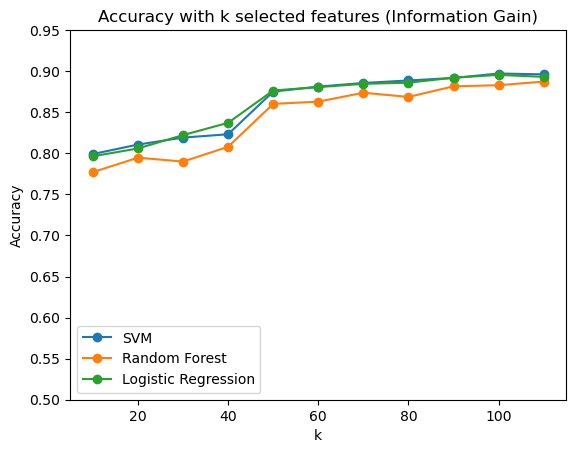

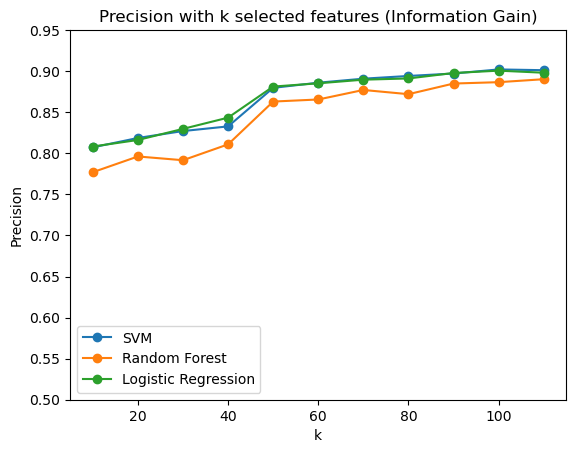

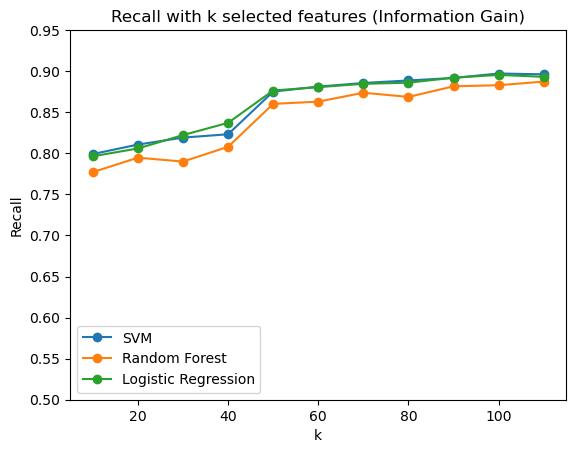

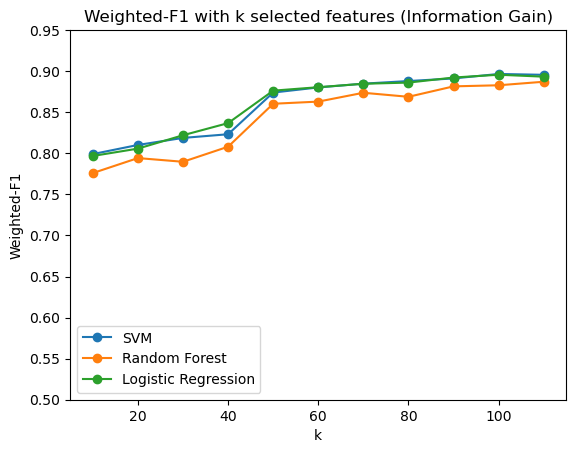

In [32]:
metrics = ["Accuracy", "Precision", "Recall", "Weighted-F1"]
for i, metric in enumerate(metrics):
    plt.plot(k_vals,[j[i] for j in eval_svc[len(k_vals):]],'o-', label="SVM")
    plt.plot(k_vals,[j[i] for j in eval_rf[len(k_vals):]],'o-', label="Random Forest")
    plt.plot(k_vals,[j[i] for j in eval_lr[len(k_vals):]],'o-' ,label="Logistic Regression")

    plt.xlabel("k")
    plt.ylabel(metric)
    plt.title(f"{metric} with k selected features (Information Gain)")
    plt.legend()
    plt.ylim(ylim)
    plt.show()

### Test model on missing data

Text(0.5, 1.0, 'Accuracy: Missing vs. no missing values')

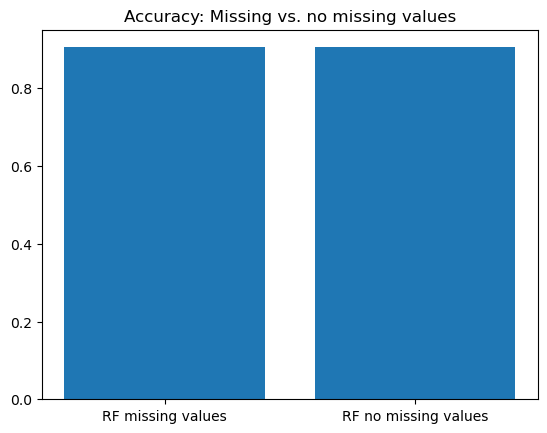

In [32]:
with open("models/rf_60.pkl", 'rb') as file:
    rf_k60 = pickle.load(file)

features_60 = rf_k60.feature_names_in_
average='weighted'


test_X_60 = missing_vals_test_df.loc[:, features_60]
test_X_60_non_missing = test_df.loc[:, features_60]

y_pred_rf_missing = rf_k60.predict(test_X_60)
y_pred_rf = rf_k60.predict(test_X_60_non_missing)

eval_missing = evaluate(test_y, y_pred_rf_missing, average)
eval = evaluate(test_y, y_pred_rf, average)

plt.bar(x=["RF missing values", "RF no missing values"], height=[eval_missing[0], eval[0]])
plt.title("Accuracy: Missing vs. no missing values")


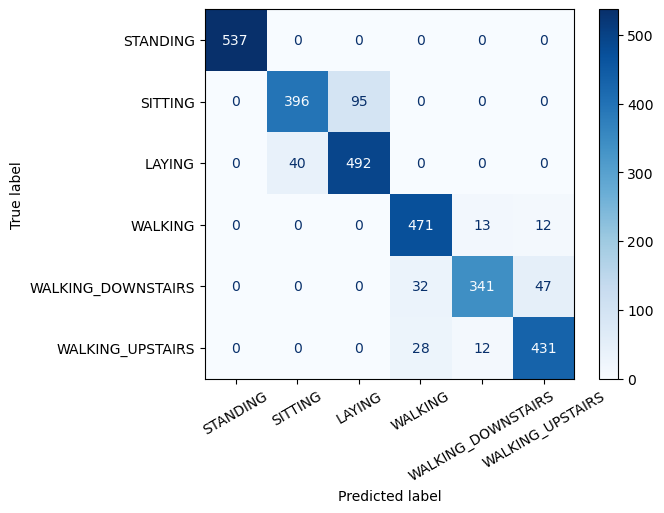

In [33]:
cm = confusion_matrix(y_true = test_y , y_pred = y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels= train_df.Activity.unique())
disp.plot(cmap ='Blues')
plt.xticks(rotation = 30)
plt.show()

### Test model on unbalanced classes

In [210]:
rf = RandomForestClassifier()
rf.fit(unbalanced_train_df.loc[:, features_60], unbalanced_train_df["Activity"])
test_X = test_df.loc[:, features_60]
test_y = test_df["Activity"]
y_pred_rf_unbalanced = rf.predict(test_X)
eval_unbalanced = evaluate(y_pred_rf_unbalanced, test_y, average)

Text(1, 0.8998982015609094, '0.9')

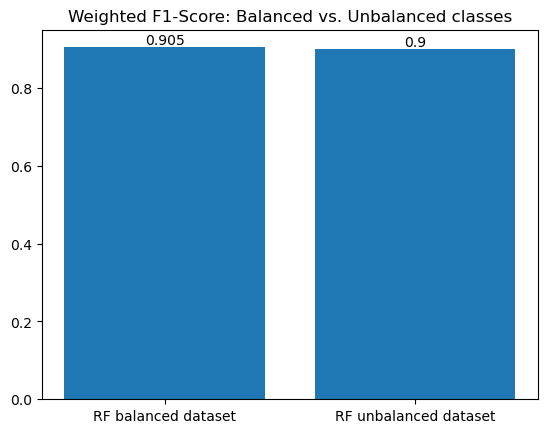

In [220]:
plt.bar(x=["RF balanced dataset", "RF unbalanced dataset"], height=[eval[3], eval_unbalanced[3]])
plt.title("Weighted F1-Score: Balanced vs. Unbalanced classes")
plt.text(0, eval[2], str(round(eval[3], 3)), ha='center', va='bottom')
plt.text(1, eval_unbalanced[2], str(round(eval_unbalanced[3], 3)), ha='center', va='bottom')

## 5. Clustering


In [27]:
from sklearn.cluster import KMeans

initial_k = len(train_y.unique())
eval_scores = []
num_features = 60
select_features_relief = relief(X, y, num_features, n_neighbors=1)
train_X_selected_features = train_X.iloc[:, select_features_relief]
kmeans = KMeans(n_clusters=initial_k, n_init="auto").fit(train_X_selected_features)
test_X = test_df.iloc[:, select_features_relief]
test_y = test_df["Activity"]
pred_y = kmeans.predict(test_X)

In [28]:
cluster_results = pd.DataFrame({f"Cluster {i}": [(test_y[pred_y == i] == j ).sum() for j in train_df["Activity"].unique()] for i in range(initial_k)}, index=train_df["Activity"].unique())
cluster_results

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
STANDING,514,0,18,0,0,0
SITTING,477,0,11,3,0,0
LAYING,12,0,11,514,0,0
WALKING,0,171,11,0,46,268
WALKING_DOWNSTAIRS,0,244,10,0,87,79
WALKING_UPSTAIRS,0,92,42,0,0,337


In [93]:
test_X

,tGravityAcc-entropy()-Y,fBodyAcc-maxInds-Z,fBodyAcc-maxInds-X,fBodyAcc-maxInds-Y,fBodyGyro-maxInds-Z,fBodyGyro-maxInds-Y,fBodyGyro-maxInds-X,fBodyAccMag-maxInds,fBodyBodyGyroMag-maxInds,fBodyBodyAccJerkMag-maxInds,...,tBodyAccMag-min(),tGravityAccMag-min(),tBodyAccJerkMag-min(),tBodyGyroMag-min(),tBodyGyroJerkMag-min(),tGravityAcc-max()-Z,tGravityAcc-min()-X,fBodyAccMag-entropy(),tGravityAcc-max()-Y,clusters
0,-1.0,-1.000000,-1.000000,-1.000000,-0.931034,-0.935484,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.981649,-0.981649,-0.975011,-0.764193,-0.976367,0.152895,0.944461,-0.174593,-0.279244,3
1,-1.0,-1.000000,-0.806452,-1.000000,-0.931034,-0.935484,-1.000000,-0.862069,-1.000000,-1.000000,...,-0.985944,-0.985944,-0.975011,-0.893753,-0.976367,0.152895,0.944461,-0.752056,-0.304870,1
2,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.935484,-1.000000,-1.000000,-0.897436,-1.000000,...,-0.985944,-0.985944,-0.983707,-0.950410,-0.974605,0.139454,0.948704,-0.816674,-0.304870,1
3,-1.0,-1.000000,-0.096774,-0.933333,-1.000000,-1.000000,-1.000000,-0.931034,-0.948718,-0.968254,...,-0.986263,-0.986263,-0.983707,-0.950410,-0.981386,0.136124,0.947309,-0.816674,-0.305101,1
4,-1.0,-0.923077,-0.548387,-0.933333,-0.931034,-0.935484,-1.000000,-0.931034,-1.000000,-0.809524,...,-0.993228,-0.993228,-0.972216,-0.969573,-0.981386,0.133541,0.946221,-0.843671,-0.312552,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,-1.0,-0.923077,-0.806452,-0.800000,-0.931034,-0.935484,-1.000000,-0.586207,-0.897436,-0.904762,...,-0.726890,-0.726890,-0.560815,-0.532111,-0.894326,-0.226640,0.903413,0.491645,-0.278442,0
2943,-1.0,-0.923077,-0.870968,-0.933333,-0.931034,-1.000000,-1.000000,-0.862069,-1.000000,-0.904762,...,-0.726890,-0.726890,-0.649986,-0.234991,-0.894326,-0.220590,0.903793,0.504386,-0.278442,0
2944,-1.0,-0.923077,-0.806452,-0.800000,-0.931034,-0.935484,-1.000000,-0.793103,-0.846154,-0.904762,...,-0.681888,-0.681888,-0.796651,0.104303,-0.799345,-0.220590,0.903793,0.392089,-0.273818,0
2945,-1.0,-0.923077,-0.806452,-0.800000,-0.931034,-0.935484,-0.933333,-0.517241,-0.846154,-0.904762,...,-0.716092,-0.716092,-0.796651,-0.369289,-0.799345,-0.231517,0.909007,0.453230,-0.272785,0


C:\Users\jonas\AppData\Local\Temp\ipykernel_14540\1716077406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X["clusters"] = pred_y


(-1.5, 0.5)

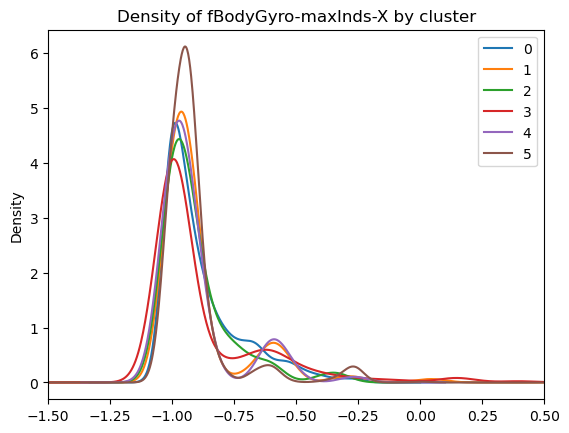

In [30]:
test_X["clusters"] = pred_y
col = "fBodyGyro-maxInds-X"
test_X.groupby('clusters')[col].plot.kde(legend=True)
plt.title("Density of " + col + " by cluster")
plt.xlim((-1.5, 0.5))

(-1.5, 0.5)

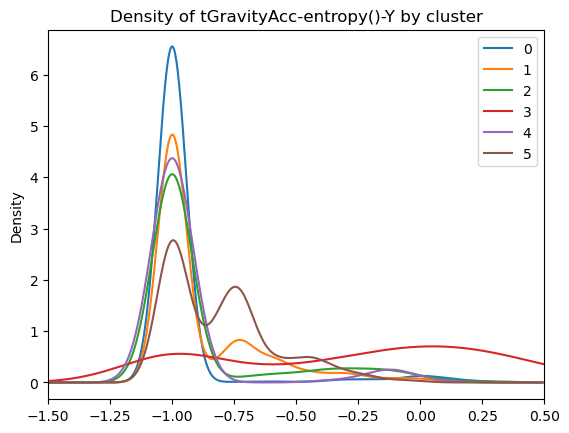

In [107]:
col = "tGravityAcc-entropy()-Y"
test_X.groupby('clusters')[col].plot.kde(legend=True)
plt.title("Density of " + col + " by cluster")
plt.xlim((-1.5, 0.5))

In [172]:
def get_high_correlated_features(correlation_matrix, threshold=0.9):
    highly_correlated_pairs = correlation_matrix.abs() > threshold # check for high absolute correlations, including negative and positive correlations
    highly_correlated_features = [(i, j) for i in range(correlation_matrix.shape[0]) for j in range(i + 1, correlation_matrix.shape[1]) if highly_correlated_pairs.iloc[i, j]]
    return highly_correlated_features

correlations_foreach_cluster = test_X.groupby('clusters').corr()
for cluster in range(len(test_X.clusters.unique())):
    corr_in_cluster = correlations_foreach_cluster.loc[cluster]
    print("Cluster: ", cluster)
    print(get_high_correlated_features(corr_in_cluster))

Cluster:  0
[(26, 27), (51, 52)]
Cluster:  1
[(12, 30), (13, 20), (26, 27), (51, 52)]
Cluster:  2
[(26, 27), (51, 52)]
Cluster:  3
[(18, 19), (18, 23), (18, 50), (19, 23), (26, 27), (51, 52)]
Cluster:  4
[(18, 23), (26, 27), (51, 52)]
Cluster:  5
[(13, 20), (16, 29), (16, 36), (18, 19), (18, 23), (18, 50), (26, 27), (26, 58), (27, 58), (30, 32), (51, 52)]


In [83]:
# cluster_results.to_excel('cluster.xlsx', index=True)